# Multi-Resolution Component Separation with HEALPix ud_grade

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/CMBSciPol/furax-cs/blob/main/notebooks/03_PTEP_Multi_Resolution_Component_Separation.ipynb)

## Learning Objectives

By the end of this notebook, you will:
- Understand multi-resolution component separation using HEALPix ud_grade
- Implement resolution-based parameter optimization for CMB analysis
- Optimize spectral parameters at different spatial scales
- Visualize how resolution-based parameterization improves computational efficiency

## The Multi-Resolution Approach

Traditional component separation uses uniform resolution across all parameters. The PTEP (LiteBIRD Physics, Technology, and Engineering Plan) approach recognizes that different astrophysical parameters vary at different spatial scales. This method uses HEALPix `ud_grade` to downsample parameter maps to appropriate resolutions.

**Key Innovation**: Optimize spectral parameters at resolution scales matched to their astrophysical variation, reducing computational cost while maintaining accuracy.

In [ ]:
!pip install -q furax-cs
!pip install -r https://raw.githubusercontent.com/CMBSciPol/furax-cs/main/requirements.txt

In [2]:
# Setup and Data Loading


# Core libraries
# Data utilities
from functools import partial

import furax_cs as fcs
import healpy as hp

# JAX ecosystem
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

# FURAX framework
from furax import HomothetyOperator
from furax.obs import negative_log_likelihood, sky_signal
from furax.obs.stokes import Stokes

# JAX-HEALPix for mask and map operations
from jax_healpy.clustering import get_cutout_from_mask, get_fullmap_from_cutout

# Configure JAX
jax.config.update("jax_enable_x64", True)

ERROR:2026-02-01 21:50:34,703:jax._src.xla_bridge:491: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/home/wassim/micromamba/envs/fg/lib/python3.11/site-packages/jax/_src/xla_bridge.py", line 489, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/home/wassim/micromamba/envs/fg/lib/python3.11/site-packages/jax_plugins/xla_cuda12/__init__.py", line 328, in initialize
    _check_cuda_versions(raise_on_first_error=True)
  File "/home/wassim/micromamba/envs/fg/lib/python3.11/site-packages/jax_plugins/xla_cuda12/__init__.py", line 285, in _check_cuda_versions
    local_device_count = cuda_versions.cuda_device_count()
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: jaxlib/cuda/versions_helpers.cc:113: operation cuInit(0) failed: CUDA_ERROR_UNKNOWN
/home/wassim/micromamba/envs/fg/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please up

In [3]:
# Load CMB and foreground data
nside = 64
npixels = 12 * nside**2

# Generate and load multi-frequency data
fcs.save_to_cache(nside, sky="c1d1s1")
nu, freq_maps = fcs.load_from_cache(nside, sky="c1d1s1")
print(f"Frequency maps shape: {freq_maps.shape}")
print(f"Frequencies: {len(nu)} bands from {nu[0]:.0f} to {nu[-1]:.0f} GHz")

# Convert to FURAX format (Q,U polarization)
d = Stokes.from_stokes(Q=freq_maps[:, 1, :], U=freq_maps[:, 2, :])

# Load galactic mask (cleanest 20% of sky)
mask = fcs.get_mask("GAL020", nside=nside)
(indices,) = jnp.where(mask == 1)
coverage = jnp.mean(mask) * 100
print(f"Sky coverage: {coverage:.1f}% ({len(indices):,} pixels)")

# Extract masked data for computation
masked_d = get_cutout_from_mask(d, indices, axis=1)
print(f"Masked data shape: {masked_d.shape}")

/home/wassim/Projects/CMB/furax-compsep-paper/src/furax_cs/data/instruments.py:41: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  return FGBusterInstrument(frequency, depth_i, depth_p)


[INFO] Loaded freq_maps for nside 64 from cache with noise_ratio 0.0.
[INFO] Loaded freq_maps for nside 64 from cache.
Frequency maps shape: (15, 3, 49152)
Frequencies: 15 bands from 40 to 402 GHz
Sky coverage: 19.7% (9,695 pixels)
Masked data shape: (15, 9695)


## Step 2: Multi-Resolution Patch Generation

The PTEP method uses HEALPix `ud_grade` to create resolution-based patches:

### How ud_grade Works
1. **Downgrade**: Map pixels to lower resolution (fewer pixels)
2. **Upgrade**: Map back to original resolution
3. **Result**: Pixels that share the same low-res pixel become a patch

### Resolution Choices
- **beta_dust** (nside=64): Full resolution - varies pixel-by-pixel
- **temp_dust** (nside=32): 4x fewer patches - varies more slowly
- **beta_pl** (nside=16): 16x fewer patches - varies most slowly

This reduces the parameter count significantly while preserving physical variation scales.

In [4]:
# Multi-Resolution Patch Generation

# Configure resolution parameters for different spectral indices
target_ud_grade = {
    "beta_dust": 64,
    "temp_dust": 32,
    "beta_pl": 16,
}
ud_beta_d = target_ud_grade["beta_dust"]
ud_temp_d = target_ud_grade["temp_dust"]
ud_beta_pl = target_ud_grade["beta_pl"]

print("Multi-resolution configuration:")
print(f"  Dust spectral index (beta_dust): nside={ud_beta_d} ({12 * ud_beta_d**2:,} pixels)")
print(f"  Dust temperature (temp_dust): nside={ud_temp_d} ({12 * ud_temp_d**2:,} pixels)")
print(f"  Synchrotron index (beta_pl): nside={ud_beta_pl} ({12 * ud_beta_pl**2:,} pixels)")

# Generate resolution-based patch indices
print("\nGenerating multi-resolution patches...")
masked_patches = fcs.multires_clusters(mask, indices, target_ud_grade, nside)

# Count unique patches for each parameter
max_count = {
    key.replace("_patches", ""): int(jnp.unique(val).size) for key, val in masked_patches.items()
}

print("Resolution patch counts:")
for param, count in max_count.items():
    print(f"  {param}: {count} patches")

Multi-resolution configuration:
  Dust spectral index (beta_dust): nside=64 (49,152 pixels)
  Dust temperature (temp_dust): nside=32 (12,288 pixels)
  Synchrotron index (beta_pl): nside=16 (3,072 pixels)

Generating multi-resolution patches...
Resolution patch counts:
  beta_dust: 9695 patches
  beta_pl: 682 patches
  temp_dust: 2516 patches


# Visualize Clusters

Consider using `from jax_healpy.clustering._clustering import shuffle_labels` to shuffle cluster labels for better visualization.


/tmp/ipykernel_100842/3775188447.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


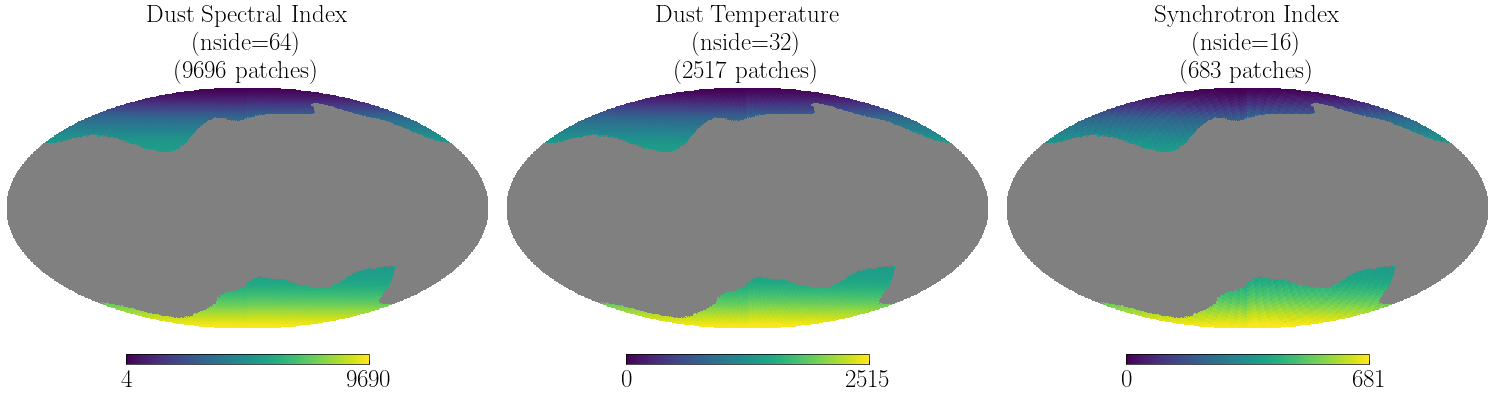

Multi-resolution patches ready for optimization


In [5]:
# Visualize the multi-resolution patches
fig = plt.figure(figsize=(15, 5))

param_labels = [
    "Dust Spectral Index\n(nside=64)",
    "Dust Temperature\n(nside=32)",
    "Synchrotron Index\n(nside=16)",
]
patch_maps = get_fullmap_from_cutout(masked_patches, indices, nside=nside)
patch_maps = [
    patch_maps["beta_dust_patches"],
    patch_maps["temp_dust_patches"],
    patch_maps["beta_pl_patches"],
]

for i, (label, patch_map) in enumerate(zip(param_labels, patch_maps)):
    n_unique = np.unique(patch_map).size

    hp.mollview(
        patch_map, title=f"{label}\n({n_unique} patches)", sub=(1, 3, i + 1), bgcolor=(0.0,) * 4
    )

plt.tight_layout()
plt.show()

print("Multi-resolution patches ready for optimization")

## Step 3: Parameter Optimization

With resolution-based patches defined, we optimize spectral parameters at each patch.

### Computational Advantage
- Full resolution: 49,152 parameters per spectral index
- PTEP approach: 9,695 + 2,516 + 682 = 12,893 total parameters
- **3.8x reduction** in parameter count

### Physical Justification
- Dust temperature varies on ~1° scales → nside=32 sufficient
- Synchrotron index varies on ~3° scales → nside=16 sufficient
- Dust spectral index has finer structure → nside=64 needed

In [6]:
# Parameter Optimization

# Setup optimization parameters
dust_nu0 = 160.0  # Dust reference frequency (GHz)
synchrotron_nu0 = 20.0  # Synchrotron reference frequency (GHz)

# Create objective function with fixed reference frequencies
negative_log_likelihood_fn = partial(
    negative_log_likelihood,
    dust_nu0=dust_nu0,
    synchrotron_nu0=synchrotron_nu0,
    analytical_gradient=True,
)

sky_signal_fn = partial(sky_signal, dust_nu0=dust_nu0, synchrotron_nu0=synchrotron_nu0)

# Initialize parameters for each resolution level (realistic starting values)
base_params = {
    "beta_dust": 1.54,  # Dust spectral index
    "temp_dust": 20.0,  # 20K dust temperature
    "beta_pl": -3.0,  # Synchrotron index
}

initial_params = jax.tree.map(lambda v, c: jnp.full((c,), v), base_params, max_count)

print("Parameter initialization:")
for param, values in initial_params.items():
    print(f"  {param}: {len(values)} patches at resolution, initial value = {values[0]}")

# Create noise operator (simplified for demonstration)
N = HomothetyOperator(jnp.ones(1), _in_structure=masked_d.structure)

print("\nRunning multi-resolution optimization...")
print("This may take a few minutes...")

# Run optimization using unified minimize API
final_params, final_state = fcs.minimize(
    fn=negative_log_likelihood_fn,
    init_params=initial_params,
    solver_name="optax_lbfgs",
    max_iter=1000,
    rtol=1e-16,
    atol=1e-16,
    precondition=True,
    nu=nu,
    N=N,
    d=masked_d,
    patch_indices=masked_patches,
)

# Show optimization results
print("\nOptimization completed!")
print(f"Final function value: {final_state.best_loss:.2e}")

Parameter initialization:
  beta_dust: 9695 patches at resolution, initial value = 1.54
  beta_pl: 682 patches at resolution, initial value = -3.0
  temp_dust: 2516 patches at resolution, initial value = 20.0

Running multi-resolution optimization...
This may take a few minutes...


100.00%|██████████| [10:04<00:00,  6.05s/%]


Optimization completed!
Final function value: -7.39e+04


In [7]:
final_state

UnifiedState(
  best_loss=f64[],
  best_y={'beta_dust': f64[9695], 'beta_pl': f64[682], 'temp_dust': f64[2516]},
  iter_num=weak_i64[],
  solver_state=_BestSoFarState(
    best_y={'beta_dust': f64[9695], 'beta_pl': f64[682], 'temp_dust': f64[2516]},
    best_aux=None,
    best_loss=f64[],
    state=_OptaxState(
      step=weak_i64[],
      f=f64[],
      opt_state=(
        ScaleByLBFGSState(
          count=i32[],
          params={
            'beta_dust': f64[9695], 'beta_pl': f64[682], 'temp_dust': f64[2516]
          },
          updates={
            'beta_dust': f64[9695], 'beta_pl': f64[682], 'temp_dust': f64[2516]
          },
          diff_params_memory={
            'beta_dust': f64[10,9695],
            'beta_pl': f64[10,682],
            'temp_dust': f64[10,2516]
          },
          diff_updates_memory={
            'beta_dust': f64[10,9695],
            'beta_pl': f64[10,682],
            'temp_dust': f64[10,2516]
          },
          weights_memory=f64[10]
        

In [8]:
# Display optimized parameter statistics
print("\nOptimized parameter ranges:")
for param, values in final_params.items():
    resolution_info = {
        "beta_dust": f"nside={ud_beta_d}",
        "temp_dust": f"nside={ud_temp_d}",
        "beta_pl": f"nside={ud_beta_pl}",
    }
    print(
        f"  {param} ({resolution_info[param]}): [{jnp.min(values):.3f}, {jnp.max(values):.3f}], "
        f"mean = {jnp.mean(values):.3f} ± {jnp.std(values):.3f}"
    )

# Compute CMB reconstruction with optimized parameters
reconstructed_signal = sky_signal_fn(
    final_params, nu=nu, d=masked_d, N=N, patch_indices=masked_patches
)
cmb_reconstruction = reconstructed_signal["cmb"]
print("\nCMB reconstruction completed")
print(f"CMB shape: Q={cmb_reconstruction.q.shape}, U={cmb_reconstruction.u.shape}")


Optimized parameter ranges:
  beta_dust (nside=64): [1.366, 2.585], mean = 1.614 ± 0.054
  beta_pl (nside=16): [-3.163, -2.312], mean = -3.012 ± 0.056
  temp_dust (nside=32): [15.672, 26.297], mean = 20.856 ± 0.931

CMB reconstruction completed
CMB shape: Q=(9695,), U=(9695,)


## Step 4: Parameter Map Reconstruction

The optimized parameters are mapped back to full resolution:
1. Each pixel gets the value from its resolution patch
2. The result shows the multi-resolution structure
3. Lower-resolution parameters appear as larger uniform regions

In [9]:
# Parameter Map Reconstruction

# Map cluster parameters back to full sky maps
print("Reconstructing full-sky parameter maps...")

param_maps = {}
for param_name in ["temp_dust", "beta_dust", "beta_pl"]:
    # Get optimized parameter values for each cluster
    param_values = final_params[param_name]
    cluster_indices = masked_patches[f"{param_name}_patches"]

    # Map parameter values to masked pixels using cluster assignments
    param_map_masked = param_values[cluster_indices]

    # Convert back to full HEALPix map
    full_param_map = get_fullmap_from_cutout(param_map_masked, indices, nside=nside)
    param_maps[param_name] = full_param_map

print("Parameter map reconstruction completed!")

# Also reconstruct CMB maps for visualization
cmb_q_full = get_fullmap_from_cutout(cmb_reconstruction.q, indices, nside=nside)
cmb_u_full = get_fullmap_from_cutout(cmb_reconstruction.u, indices, nside=nside)

print("CMB maps reconstructed to full sky")
print(f"Parameter maps available: {list(param_maps.keys())}")

# Display parameter statistics
print("\\nFull-sky parameter statistics:")
for param_name, param_map in param_maps.items():
    valid_data = param_map[param_map != hp.UNSEEN]
    if len(valid_data) > 0:
        print(
            f"  {param_name}: [{jnp.min(valid_data):.3f}, {jnp.max(valid_data):.3f}], "
            f"mean = {jnp.mean(valid_data):.3f} ± {jnp.std(valid_data):.3f}"
        )
    else:
        print(f"  {param_name}: No valid data")

Reconstructing full-sky parameter maps...
Parameter map reconstruction completed!
CMB maps reconstructed to full sky
Parameter maps available: ['temp_dust', 'beta_dust', 'beta_pl']
\nFull-sky parameter statistics:
  temp_dust: [15.672, 26.297], mean = 20.866 ± 0.937
  beta_dust: [1.366, 2.585], mean = 1.614 ± 0.054
  beta_pl: [-3.163, -2.312], mean = -3.015 ± 0.048


/tmp/ipykernel_100842/1189568572.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


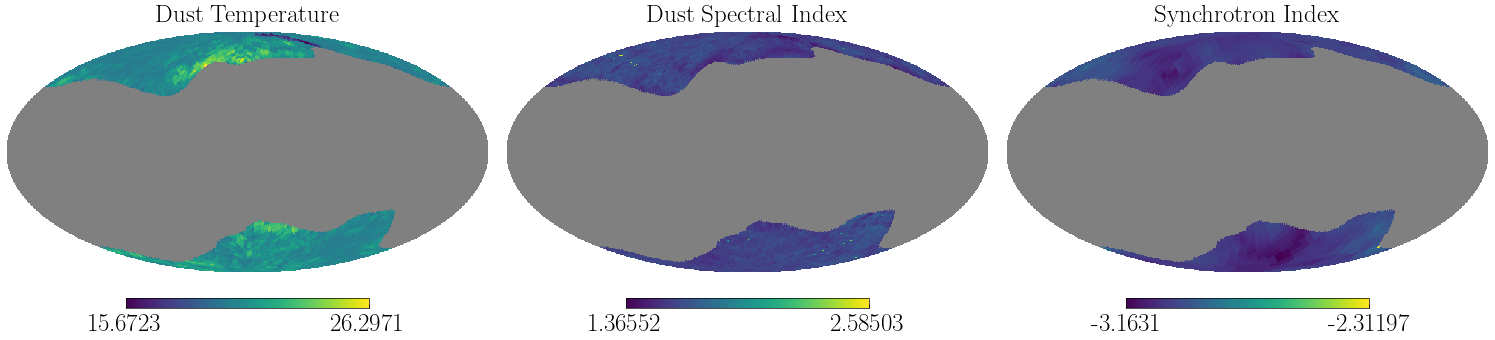

In [10]:
# Results Visualization
fig = plt.figure(figsize=(15, 5))

# Plot the three parameter maps only
hp.mollview(param_maps["temp_dust"], title="Dust Temperature", sub=(1, 3, 1), bgcolor=(0.0,) * 4)

hp.mollview(param_maps["beta_dust"], title="Dust Spectral Index", sub=(1, 3, 2), bgcolor=(0.0,) * 4)

hp.mollview(param_maps["beta_pl"], title="Synchrotron Index", sub=(1, 3, 3), bgcolor=(0.0,) * 4)

plt.tight_layout()
plt.show()

## Command-Line Tool for Large-Scale Analysis

The complete workflow demonstrated above is implemented in the production script `05-PTEP-model.py` for large-scale analysis on HPC clusters.

### Basic Usage

```bash
# Run multi-resolution PTEP component separation
!pip install furax-cs
ptep-model -n 64 -ud 64 32 16 -tag c1d1s1 -m GAL020 -i LiteBIRD

```

### Key Parameters

- `-n 64`: HEALPix resolution (nside=64 → ~55 arcmin pixels)
- `-ud 64 32 16`: Target nside values for [dust_beta, dust_temp, sync_beta] resolutions
- `-tag c1d1s1`: Sky simulation (CMB + dust + synchrotron)
- `-m GAL020`: Galactic mask (20% cleanest sky)
- `-i LiteBIRD`: Instrument configuration

### Output Structure

Results are saved to `results/PTEP_{config}_BD{ud1}_TD{ud2}_BS{ud3}_{instrument}_{mask}_{noise}/`:
- `best_params.npz`: Optimized spectral parameters per resolution
- `results.npz`: Full optimization results with resolution patches
- `mask.npy`: Sky mask used for analysis

### Scaling to Large Problems

The command-line tool provides:
- **Resolution flexibility**: Adjust parameter resolutions based on astrophysical scales
- **Computational efficiency**: Lower resolution for slowly-varying parameters
- **Monte Carlo analysis**: Multiple noise realizations (`-ns` parameter)
- **SLURM integration**: Distributed computing for GPU clusters
- **Memory optimization**: Reduced parameter space compared to full-resolution methods

## Key Benefits

1. **Computational Efficiency**: Parameters optimized at appropriate spatial scales
2. **Physical Realism**: Resolution matched to astrophysical variation scales
3. **Memory Optimization**: Reduced parameter space for slowly-varying components
4. **Baseline Compatibility**: Based on LiteBIRD PTEP methodology

This multi-resolution approach provides a computationally efficient alternative to adaptive clustering, particularly effective when astrophysical parameter variation scales are well understood.